In [1]:
import sqlite3
import csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class DatabaseManager():

    def __init__(self, database_path, data_path):
        self._database_path = database_path
        self._conn = sqlite3.connect(database_path)
        self.data_path = data_path

    def setup(self):
        conn = self._conn
        conn.execute(
            '''
CREATE TABLE assays
(
    cid VARCHAR(20) PRIMARY KEY,
    f_avg_IC50 DECIMAL not null,
    r_avg_IC50 DECIMAL not null
)
'''
        )
        conn.execute(
            '''
CREATE TABLE compounds
(
    cid VARCHAR(20) PRIMARY KEY,
    smiles VARCHAR(2000) not null,
    hbd DECIMAL,
    hba DECIMAL,
    c_logp DECIMAL,
    mw DECIMAL,
    FOREIGN KEY(cid) REFERENCES assays(cid)
)
'''
        )
        with open(self.data_path, mode='r') as file:
            csv_reader = csv.DictReader(file)
            assay_data = {}
            compound_data = {}
            for row in csv_reader:
                if row['f_avg_IC50'] and row['r_avg_IC50']:
                    CID = row['CID']
                    assay_data[CID] = (CID, row['f_avg_IC50'], row['r_avg_IC50'])
                    compound_data[CID] = (CID, row['SMILES'])
        conn.executemany('INSERT INTO assays (cid, f_avg_IC50, r_avg_IC50) VALUES (?, ?, ?)', assay_data.values())
        conn.executemany('INSERT INTO compounds (cid, smiles) VALUES (?, ?)', compound_data.values())
        conn.commit()



/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/ipykernel_33499/750103060.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
database_path = 'database.db'
data_path = 'covid_submissions_all_info.csv'

manager = DatabaseManager(database_path=database_path, data_path=data_path)
manager.setup() 

In [3]:
# Connect to the SQLite Database
conn = sqlite3.connect('database.db')  # Replace with your database path
cursor = conn.cursor()

# Fetch the SMILES strings from your table
query = "SELECT smiles FROM compounds"  # Replace with your query
cursor.execute(query)

for row in cursor.fetchall():
    smiles = row[0]
    mol = Chem.MolFromSmiles(smiles)

    MW = Descriptors.MolWt(mol)
    HBA = Descriptors.NOCount(mol)
    HBD = Descriptors.NHOHCount(mol)
    LogP = Descriptors.MolLogP(mol) 

    update_query = "UPDATE compounds SET mw=?, hba=?, hbd=?, c_logp=? WHERE smiles=?"
    cursor.execute(update_query, (MW, HBA, HBD, LogP, smiles))

conn.commit()
conn.close()


In [4]:
def rule_of_five(row):
    conditions = [row[5] <= 500, row[2] <= 10, row[3] <= 5, row[4] <= 5]
    return conditions.count(True) >= 3

In [5]:
conn = sqlite3.connect('database.db')
# Create a cursor object
cursor = conn.cursor()

cursor.execute("ALTER TABLE compounds ADD COLUMN all_satisfied BOOLEAN")

# SQL query to select data
select_query = "SELECT * FROM compounds"  # Replace 'my_table' with your table name

# Execute the select query
cursor.execute(select_query)

# Fetch all rows
rows = cursor.fetchall()

# Iterate over the rows
for row in rows:
    if rule_of_five(row):
        conditions = [row[5] <= 500, row[2] <= 10, row[3] <= 5, row[4] <= 5]
        if conditions.count(True) == 4:
            condition = True
        elif conditions.count(True) == 3:
            condition = False
        cursor.execute("UPDATE compounds SET all_satisfied=? WHERE cid=?", (condition, row[0]))
    else:
        delete_query = f"DELETE FROM compounds WHERE cid = '{row[0]}'"
        cursor.execute(delete_query)

# Commit the changes to the database
conn.commit()
conn.close()

/Users/yunliqi/ds_drug_discovery/venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


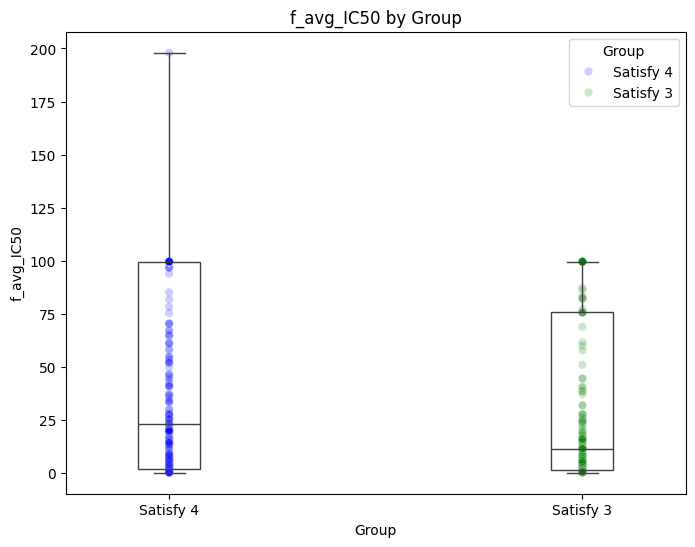

In [31]:
# Plot the figure

# Connect to the SQLite database
conn = sqlite3.connect('database.db')

# Write a SQL query to select data
query = """SELECT *
FROM assays
LEFT JOIN compounds ON assays.cid = compounds.cid
WHERE compounds.all_satisfied = True;"""

# Read the SQL query into a DataFrame
data_true = pd.read_sql_query(query, conn)
data_true['GroupNumeric'] = 0
data_true['Group'] = 'Satisfy 4'

query = """SELECT *
FROM assays
LEFT JOIN compounds ON assays.cid = compounds.cid
WHERE compounds.all_satisfied = False;"""

data_false = pd.read_sql_query(query, conn)
data_false['GroupNumeric'] = 1
data_false['Group'] = 'Satisfy 3'

# Close the connection
conn.close()

data = pd.concat([data_true, data_false], ignore_index=True)

# Adjusting the plot to include box plots
plt.figure(figsize=(8, 6))

# Creating the box plot with default settings
PROPS = {
    'boxprops':{'facecolor':'none'}
}
sns.boxplot(x='GroupNumeric', y='f_avg_IC50', data=data, width=0.15, **PROPS)

# Overlaying the scatter plot
sns.scatterplot(x='GroupNumeric', y='f_avg_IC50', hue='Group', data=data, palette=['blue', 'green'], edgecolor='w', alpha=0.2)

plt.title('f_avg_IC50 by Group')
plt.xlabel('Group')
plt.xlim(-0.25, 1.25)
plt.xticks([0, 1], ['Satisfy 4', 'Satisfy 3'])
plt.ylabel('f_avg_IC50')
plt.show()

/Users/yunliqi/ds_drug_discovery/venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


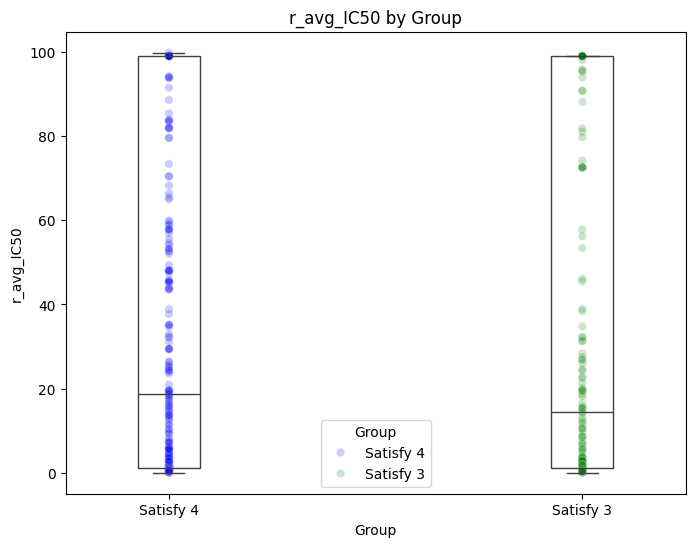

In [30]:
# Adjusting the plot to include box plots
plt.figure(figsize=(8, 6))

# Creating the box plot with default settings
PROPS = {
    'boxprops':{'facecolor':'none'}
}
sns.boxplot(x='GroupNumeric', y='r_avg_IC50', data=data, width=0.15, **PROPS)

# Overlaying the scatter plot
sns.scatterplot(x='GroupNumeric', y='r_avg_IC50', hue='Group', data=data, palette=['blue', 'green'], edgecolor='w', alpha=0.2)

plt.title('r_avg_IC50 by Group')
plt.xlabel('Group')
plt.xlim(-0.25, 1.25)
plt.xticks([0, 1], ['Satisfy 4', 'Satisfy 3'])
plt.ylabel('r_avg_IC50')
plt.show()

/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/ipykernel_32857/3974153399.py:33: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


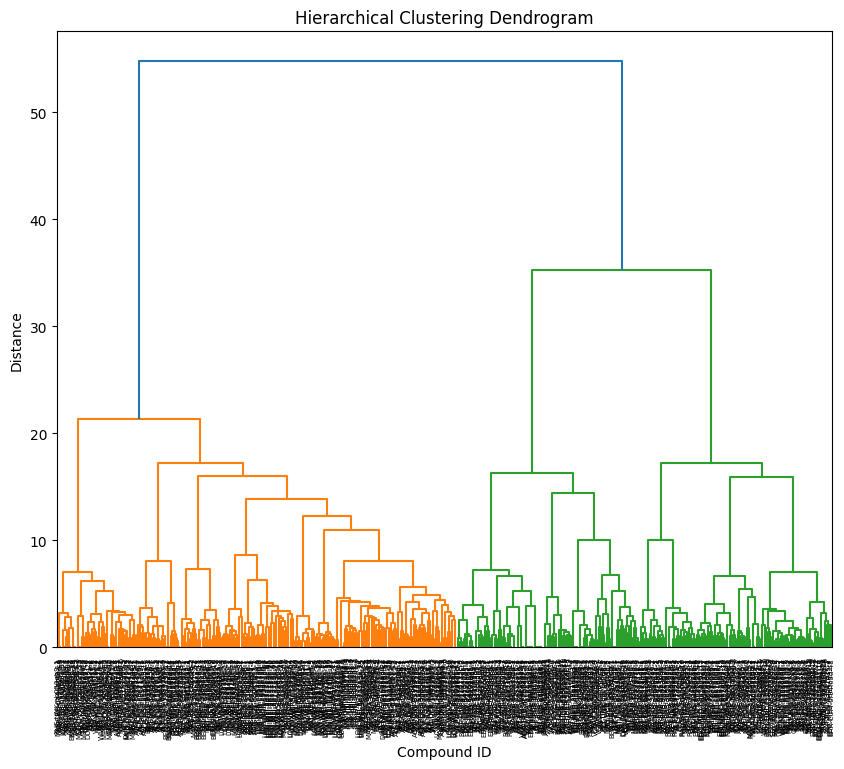

In [6]:
conn = sqlite3.connect('database.db')
# Create a cursor object
cursor = conn.cursor()

# SQL query to select data
query = "SELECT cid, smiles FROM compounds"  # Replace with your query
cursor.execute(query)
smiles_data = cursor.fetchall()

fingerprints = []
for id, smiles in smiles_data:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
    # if mol:
    #     fpgen = AllChem.GetMorganGenerator(radius=2)
    #     mol = Chem.MolFromSmiles(smiles)
    #     fp = fpgen.GetSparseCountFingerprint(mol)
        fingerprints.append((id, fp))

# Iterate over the rows
num_molecules = len(fingerprints)
distance_matrix = np.zeros((num_molecules, num_molecules))

for i in range(num_molecules):
    for j in range(num_molecules):
        # Use 1 - Tanimoto similarity as the distance
        distance = 1 - DataStructs.TanimotoSimilarity(fingerprints[i][1], fingerprints[j][1])
        distance_matrix[i, j] = distance

Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 8))
dendrogram(Z, labels=[f[0] for f in fingerprints])
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Compound ID")
plt.ylabel("Distance")
plt.show()

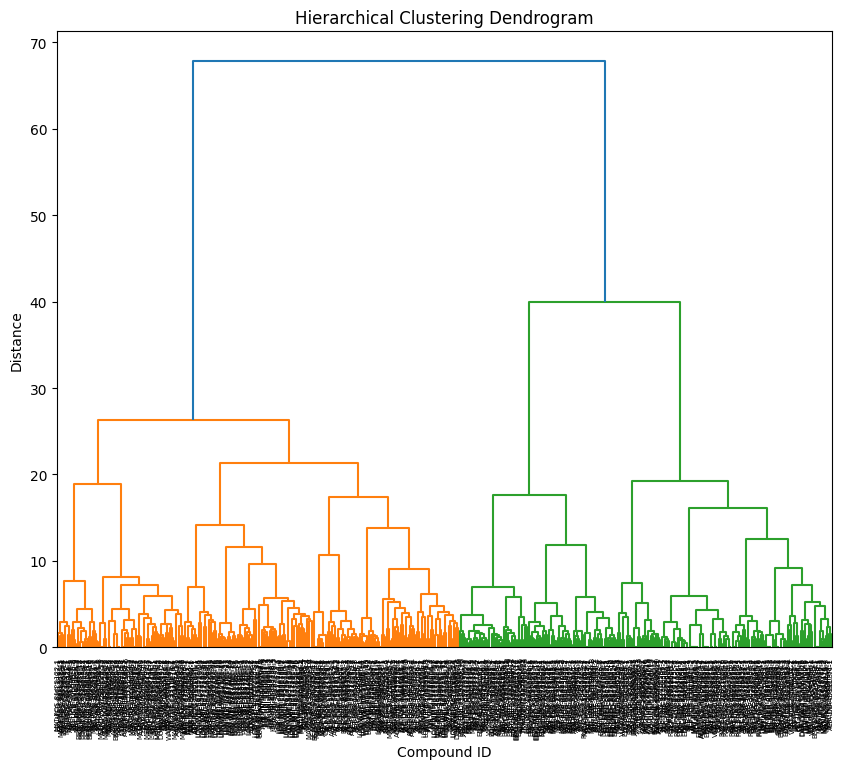

In [7]:
conn = sqlite3.connect('database.db')
# Create a cursor object
cursor = conn.cursor()

# SQL query to select data
query = "SELECT cid, smiles FROM compounds"  # Replace with your query
cursor.execute(query)
smiles_data = cursor.fetchall()

fingerprints = []
for id, smiles in smiles_data:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
    # if mol:
    #     fpgen = AllChem.GetMorganGenerator(radius=2)
    #     mol = Chem.MolFromSmiles(smiles)
    #     fp = fpgen.GetSparseCountFingerprint(mol)
        fingerprints.append((id, fp))

# Iterate over the rows
num_molecules = len(fingerprints)
distance_matrix = np.zeros((num_molecules, num_molecules))

from sklearn.metrics.pairwise import cosine_similarity
cos_fingerprints = [fp[1]for fp in fingerprints]
distance_matrix = cosine_similarity(cos_fingerprints, cos_fingerprints)
Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 8))
dendrogram(Z, labels=[f[0] for f in fingerprints])
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Compound ID")
plt.ylabel("Distance")
plt.show()